# Chapter 9 - Data Science
## Data Manipulation

## 0 - Setting up the notebook

In [1]:
import json

import arrow
import numpy as np
import pandas as pd
from pandas import DataFrame

## 1- Loading Data into a DataFrame

In [2]:
# Load data from a json file into a DataFrame
df = pd.read_json("data.json")

# let's take a peek at the first 5 rows, to make sure
# nothing weird has happened
df.head()

,cmp_name,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr,user
0,GRZ_20210131_20210411_30-40_F_GBP,253951,17953,52573,500001,"{""username"": ""susan42"", ""name"": ""Emily Smith"",..."
1,BYU_20210109_20221204_30-35_M_GBP,150314,125884,24575,499999,"{""username"": ""susan42"", ""name"": ""Emily Smith"",..."
2,GRZ_20211124_20220921_20-35_B_EUR,791397,480963,39668,499999,"{""username"": ""susan42"", ""name"": ""Emily Smith"",..."
3,GRZ_20210727_20220211_35-45_B_EUR,910204,339997,16698,500000,"{""username"": ""susan42"", ""name"": ""Emily Smith"",..."
4,BYU_20220216_20220407_20-25_F_EUR,393134,158930,46631,500000,"{""username"": ""susan42"", ""name"": ""Emily Smith"",..."


In [3]:
# OK! DataFrame is alive and well!
# let's get a sense of how many rows there are and
# what is their structure.
df.count()

cmp_name      5140
cmp_bgt       5140
cmp_spent     5140
cmp_clicks    5140
cmp_impr      5140
user          5140
dtype: int64

In [4]:
df.describe()

,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr
count,5140.000000,5140.000000,5140.000000,5140.000000
mean,496331.855058,249542.778210,40414.236576,499999.523346
std,289001.241891,219168.636408,21704.136480,2.010877
min,1017.000000,117.000000,355.000000,499991.000000
25%,250725.500000,70162.000000,22865.250000,499998.000000
50%,495957.000000,188704.000000,37103.000000,500000.000000
75%,741076.500000,381478.750000,55836.000000,500001.000000
max,999860.000000,984005.000000,98912.000000,500007.000000


In [5]:
# let's see which are the top 3 campaigns according
# to budget (regardless of the currency)
df.sort_values(by=['cmp_bgt'], ascending=False).head(3)

,cmp_name,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr,user
5047,GRZ_20210217_20220406_35-45_B_GBP,999860,791542,78932,499999,"{""username"": ""robertstephens"", ""name"": ""Jack J..."
922,AKX_20211111_20230908_40-50_M_GBP,999859,739683,73078,499996,"{""username"": ""mark20"", ""name"": ""Ronald Rojas"",..."
2113,BYU_20220330_20220401_35-45_B_USD,999696,11791,42961,499998,"{""username"": ""vkennedy"", ""name"": ""Rachel Lozan..."


In [6]:
# we can also use 'tail' to get the bottom 3 campaigns
df.sort_values(by=['cmp_bgt'], ascending=False).tail(3)

,cmp_name,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr,user
2876,KTR_20210905_20230307_30-50_M_GBP,1081,407,49358,499999,"{""username"": ""kevin28"", ""name"": ""Karen Jackson..."
1182,AKX_20210527_20220128_35-45_B_EUR,1054,392,36790,500000,"{""username"": ""speters"", ""name"": ""Aaron Shelton..."
1954,BYU_20201018_20220904_25-40_F_GBP,1017,224,62568,500002,"{""username"": ""cdavis"", ""name"": ""Mrs. Kimberly ..."


## 2 - Manipulating the DataFrame

In [7]:
# first, let's explode cmp_name into its components
# and get a separate DataFrame for those

def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split('_')
    start = arrow.get(start, 'YYYYMMDD').date()
    end = arrow.get(end, 'YYYYMMDD').date()
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name)
campaign_cols = [
    'Type', 'Start', 'End', 'Target Age', 'Target Gender',
    'Currency']
campaign_df = DataFrame(
    campaign_data.tolist(), columns=campaign_cols, index=df.index)
campaign_df.head(3)

,Type,Start,End,Target Age,Target Gender,Currency
0,GRZ,2021-01-31,2021-04-11,30-40,F,GBP
1,BYU,2021-01-09,2022-12-04,30-35,M,GBP
2,GRZ,2021-11-24,2022-09-21,20-35,B,EUR


In [8]:
# let's join the two dataframes
df = df.join(campaign_df)

In [9]:
# and take a peek: good! It seems to be ok.
df[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Target Age,Target Gender,Currency
0,GRZ_20210131_20210411_30-40_F_GBP,GRZ,2021-01-31,2021-04-11,30-40,F,GBP
1,BYU_20210109_20221204_30-35_M_GBP,BYU,2021-01-09,2022-12-04,30-35,M,GBP
2,GRZ_20211124_20220921_20-35_B_EUR,GRZ,2021-11-24,2022-09-21,20-35,B,EUR


In [10]:
# now let's do the same for the JSON user object

def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
    ]

user_data = df['user'].apply(unpack_user_json)
user_cols = [
    'Username', 'Email', 'Name', 'Gender', 'Age', 'Address']
user_df = DataFrame(
    user_data.tolist(), columns=user_cols, index=df.index)

In [11]:
# let's join the two dataframes
df = df.join(user_df)

In [12]:
# and take a peek: good! Still in good shape.
df[['user'] + user_cols].head(2)

,user,Username,Email,Name,Gender,Age,Address
0,"{""username"": ""susan42"", ""name"": ""Emily Smith"",...",susan42,vmckinney@leon.com,Emily Smith,F,53,"66537 Riley Mission Apt. 337\nNorth Jennifer, ..."
1,"{""username"": ""susan42"", ""name"": ""Emily Smith"",...",susan42,vmckinney@leon.com,Emily Smith,F,53,"66537 Riley Mission Apt. 337\nNorth Jennifer, ..."


In [13]:
# now we have the DataFrame completely expanded, so it's
# time to play with it. First, let's fix those ugly column names
new_column_names = {
    'cmp_bgt': 'Budget',
    'cmp_spent': 'Spent',
    'cmp_clicks': 'Clicks',
    'cmp_impr': 'Impressions',
}
df.rename(columns=new_column_names, inplace=True)

In [14]:
# let's add three other columns

def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df['Impressions']
    
calculate_extra_columns(df)

In [15]:
# let's take a peek
df[['Spent', 'Clicks', 'Impressions',
    'CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,17953,52573,500001,0.105146,0.341487,0.035906
1,125884,24575,499999,0.049150,5.122442,0.251769
2,480963,39668,499999,0.079336,12.124710,0.961928


In [16]:
# let's take the values of the first row and verify
clicks = df['Clicks'][0]
impressions = df['Impressions'][0]
spent = df['Spent'][0]

CTR = df['CTR'][0]
CPC = df['CPC'][0]
CPI = df['CPI'][0]

print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.10514578970842059 0.10514578970842059
CPC: 0.3414870751146026 0.3414870751146026
CPI: 0.03590592818814362 0.03590592818814362


In [17]:
# let's also add the name of the Day when campaign starts
def get_day_of_the_week(day):
    return day.strftime("%A")

def get_duration(row):
    return (row['End'] - row['Start']).days

df['Day of Week'] = df['Start'].apply(get_day_of_the_week)
df['Duration'] = df.apply(get_duration, axis=1)

In [18]:
# let's verify
df[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2021-01-31,2021-04-11,70,Sunday
1,2021-01-09,2022-12-04,694,Saturday
2,2021-11-24,2022-09-21,301,Wednesday


In [19]:
# now let's get rid of the cmp_name and user columns,
# which we don't need any more, and address too
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]
df = df[final_columns]

## 3 - Saving to a file in different formats

In [20]:
# CSV format
df.to_csv('df.csv')

In [21]:
# JSON format
df.to_json('df.json')

In [22]:
# Spreadsheet format
df.to_excel('df.xlsx')

## 4 - Visualizing results

First let's take care of the graphics, we configure the `matplotlib` plot stle and set the font family to `serif`.

In [23]:
%matplotlib inline

In [24]:
# make the graphs nicer
import matplotlib.pyplot as plt
plt.style.use(['classic', 'ggplot'])
# see all available with: print(plt.style.available)
plt.rc('font', family='serif')

In [25]:
df.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000
mean,365.923930,496331.855058,40414.236576,499999.523346,249542.778210,0.080829,9.816749,0.499086,55.503891
std,213.233798,289001.241891,21704.136480,2.010877,219168.636408,0.043408,17.649877,0.438338,20.803059
min,1.000000,1017.000000,355.000000,499991.000000,117.000000,0.000710,0.003580,0.000234,18.000000
25%,180.000000,250725.500000,22865.250000,499998.000000,70162.000000,0.045730,1.778724,0.140325,38.000000
50%,369.000000,495957.000000,37103.000000,500000.000000,188704.000000,0.074206,4.977531,0.377409,56.000000
75%,553.000000,741076.500000,55836.000000,500001.000000,381478.750000,0.111673,11.620850,0.762962,73.000000
max,730.000000,999860.000000,98912.000000,500007.000000,984005.000000,0.197824,517.287324,1.968014,90.000000


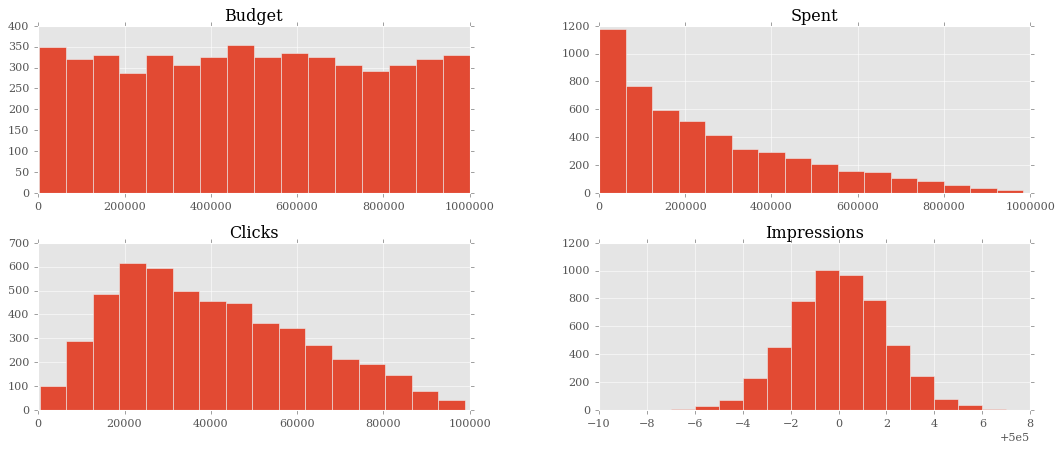

In [26]:
df[['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=16, figsize=(16, 6));

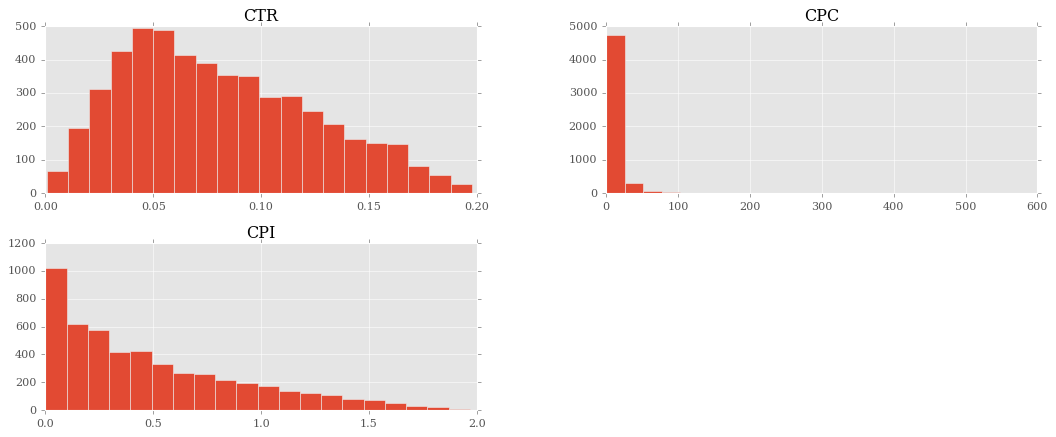

In [27]:
df[['CTR', 'CPC', 'CPI']].hist(
    bins=20, figsize=(16, 6));

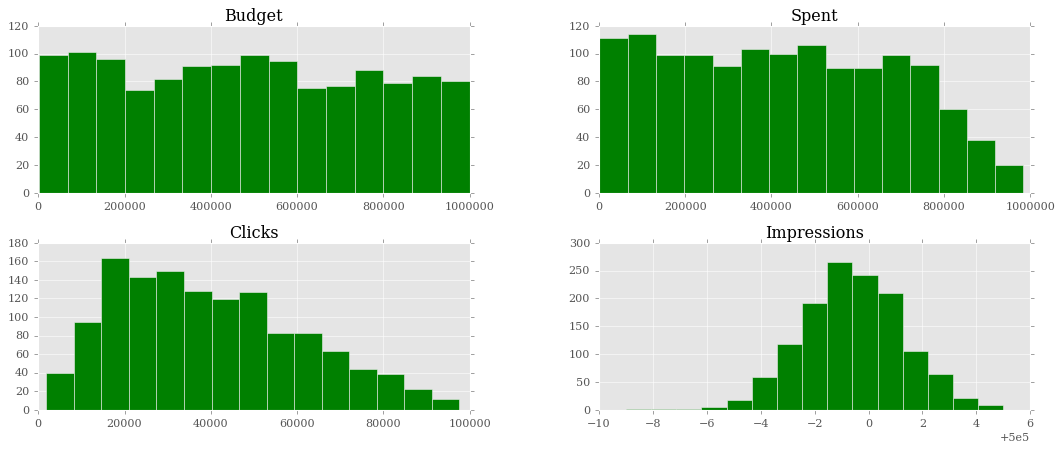

In [28]:
# let's see the campaigns whose spent is > than 75% of the budget
selector = (df.Spent > df.Budget * .75)
df[selector][['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=15, figsize=(16, 6), color='green');

In [29]:
# Let's aggregate by Day of the Week
df_weekday = df.groupby(['Day of Week']).sum()
df_weekday[['Impressions', 'Spent', 'Clicks']].plot(
    figsize=(16, 6), subplots=True);

TypeError: unsupported operand type(s) for +: 'datetime.date' and 'datetime.date'

In [ ]:
# Let's aggregate by gender and age
agg_config = {
    'Impressions': ['mean', 'std'],
    'Spent': ['mean', 'std'],
}

df.groupby(['Target Gender', 'Target Age']).agg(agg_config)

Impressions                    Spent  \
                                   mean       std           mean   
Target Gender Target Age                                           
B             20-25       499999.513514  2.068970  225522.364865   
              20-30       499999.233766  2.372519  248960.376623   
              20-35       499999.678161  1.742053  280387.114943   
              20-40       499999.566265  1.761324  235929.072289   
              20-45       499999.350000  2.323224  265572.050000   
...                                 ...       ...            ...   
M             45-50       499999.000000  1.490712  323302.200000   
              45-55       499999.142857  1.956674  344844.142857   
              45-60       499999.750000  1.332785  204209.750000   
              45-65       500000.125000  1.356203  249832.375000   
              45-70       500000.000000  0.000000  227598.500000   

                                         
                                    std  
Target Gender Target Age                 
B             20-25       210082.169476  
              20-30       247992.581816  
              20-35       229581.623961  
              20-40       206375.966516  
              20-45       269311.696990  
...                                 ...  
M             45-50       231532.010005  
              45-55       238843.833685  
              45-60       161287.282792  
              45-65       190022.680442  
              45-70        13319.770437  

[90 rows x 4 columns]

In [ ]:
# finally, let's make a pivot table
df.pivot_table(
    values=['Impressions', 'Clicks', 'Spent'],
    index=['Target Age'],
    columns=['Target Gender'],
    aggfunc=np.sum
)

Clicks                   Impressions                      \
Target Gender        B        F        M           B         F         M   
Target Age                                                                 
20-25          2866528  2736143  3752471    36999964  35499973  42499984   
20-30          3377741  3479775  3297034    38499941  39999978  39499933   
20-35          2978342  2727771  2981045    43499972  34499979  38499964   
20-40          3312590  3269549  3163736    41499964  40499964  37999981   
20-45           760654   984872   774256     9999987   8999992   8499991   
25-30          2599444  2548985  3497998    35499970  35499986  41999977   
25-35          3576868  4024268  3019695    45999983  54999959  37999944   
25-40          2907057  2646312  3511864    36499966  36499976  41999946   
25-45          2623823  2820536  2871440    34999991  35499952  32999963   
25-50           462439   753028   654451     6499999   9499976   9499977   
30-35          3388423  2994753  3490426    43999983  38999956  41499932   
30-40          3242415  3736380  3449705    39499954  44499959  42499939   
30-45          3275455  2538368  4259140    36999967  33499981  49999943   
30-50          2854116  2995629  3566316    36999929  36999970  42999951   
30-55          1041929   607846   387337    11499978   7499997   3999986   
35-40          3147055  3573129  3374785    38999963  41499979  41499969   
35-45          3201399  2874475  2412763    39999945  36499964  29999965   
35-50          3078118  3386987  3153942    38999949  39499974  42999947   
35-55          3139403  3086026  3845534    38999981  39499951  42000006   
35-60           293481  1122466   448415     3999983  11499987   8000000   
40-45          2852606  2792697  3101402    33999974  32499975  36499991   
40-50          3188184  2997715  3138284    39999955  37999960  39999983   
40-55          3450353  3329375  3543599    39499918  43999982  40999954   
40-60          3345556  2923719  3303711    41999951  35999952  39499956   
40-65           287297   660921   250325     4999989   8000000   4499993   
45-50           415484   542915   414364     4999998   5999983   4999990   
45-55           686640   709173   975872     8999983   7999994  10499982   
45-60           850162   718080   817504     7999995   9999982   9999995   
45-65           376761   573359   297859     4499991   6999997   4000001   
45-70            79339   116934    42055     1500004   1500002   1000000   

                  Spent                      
Target Gender         B         F         M  
Target Age                                   
20-25          16688655  15609550  22026226  
20-30          19169949  17810108  15777111  
20-35          24393679  18132970  17653304  
20-40          19582113  22317003  19464410  
20-45           5311441   3461947   5014206  
25-30          16049379  18844103  19496786  
25-35          22770720  31594555  19591946  
25-40          21124388  17382281  24660000  
25-45          20549561  19928836  16185794  
25-50           3403975   3707541   3496496  
30-35          26164157  15885285  18907029  
30-40          19181696  18973465  18056334  
30-45          20123897  20192858  24024862  
30-50          17925687  15820300  21335822  
30-55           5860019   4143309   2250109  
35-40          20706965  17297514  18888529  
35-45          20057967  19478538  12951974  
35-50          18324889  18508732  20743245  
35-55          19983051  24899403  20362757  
35-60           1813803   6365702   5748788  
40-45          15996311  16584837  19899182  
40-50          17335121  16583301  23051858  
40-55          21237290  23043570  18746124  
40-60          19952503  17564038  19037412  
40-65           2527973   3831662   2226148  
45-50           2092140   4535643   3233022  
45-55           5515044   3716558   7241727  
45-60           3666221   6606485   4084195  
45-65           1838801   2573360   1998659  
45-70            835152    464627  